Ran `CountTopMarkets` scala script for 08/19 - 09/06. Figure out how to combine / analyze counts across various day, and reduce top list to 1000

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [2]:
# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
APP_NAME = "KF-TopMarketsAnalysis"

# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
#         ("spark.master","yarn"),
        ("spark.driver.memory","10g"),
#         ("spark.executor.memory", "10g"),
#         ("spark.executor.instances", 5),
#         ("spark.executor.cores", "5"),
#         ('spark.sql.crossJoin.enabled', True),
#         ('spark.sql.shuffle.partitions', 8) 
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

In [4]:
spark.sparkContext.applicationId

'local-1662567981423'

# load data

In [6]:
inputPath = "/user/kendra.frederick/lookups/top_markets/top_10000/"

In [8]:
!hdfs dfs -ls $inputPath > temp.txt

In [5]:
with open('temp.txt') as file:
    tempList = file.readlines()[1:]

In [7]:
tempList[:5]

['drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-07 16:14 /user/kendra.frederick/lookups/top_markets/top_10000/20220819.csv\n',
 'drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-02 19:23 /user/kendra.frederick/lookups/top_markets/top_10000/20220820.csv\n',
 'drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-06 23:02 /user/kendra.frederick/lookups/top_markets/top_10000/20220821.csv\n',
 'drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-02 20:35 /user/kendra.frederick/lookups/top_markets/top_10000/20220822.csv\n',
 'drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-02 20:44 /user/kendra.frederick/lookups/top_markets/top_10000/20220823.csv\n']

In [8]:
x = tempList[0] 

In [9]:
x.split(" ")[-1].strip()

'/user/kendra.frederick/lookups/top_markets/top_10000/20220819.csv'

In [23]:
path = x.split(" ")[-1].strip()
date = path.split("/")[-1].rstrip(".csv")
date

'20220819'

In [11]:
dataList = [x.split(" ")[-1].strip() for x in tempList]

In [17]:
df = spark.read.csv(dataList[0], header=True, inferSchema=True)

In [18]:
df.show(5)

+----------------+---------------------+---------+----------------+-------------+------------------+-------+
|outOriginAirport|outDestinationAirport|    count|num_unique_shops|originDecoded|destinationDecoded| market|
+----------------+---------------------+---------+----------------+-------------+------------------+-------+
|       118296576|             50992384|241499097|          129610|          GMP|               CJU|GMP-CJU|
|       369823488|            152245248|206656505|          855697|          VKO|               IST|VKO-IST|
|       201855488|            168168192|206072050|          651472|          LHR|               JFK|LHR-JFK|
|       369823488|             34215424|165926800|           95982|          VKO|               BJV|VKO-BJV|
|       369823488|             18420736|164549588|          550482|          VKO|               AYT|VKO-AYT|
+----------------+---------------------+---------+----------------+-------------+------------------+-------+
only showing top 5 

In [19]:
df.orderBy(F.desc("num_unique_shops")).show()

+----------------+---------------------+---------+----------------+-------------+------------------+-------+
|outOriginAirport|outDestinationAirport|    count|num_unique_shops|originDecoded|destinationDecoded| market|
+----------------+---------------------+---------+----------------+-------------+------------------+-------+
|        67962112|            152245248| 36884126|         1040032|          DME|               IST|DME-IST|
|       369823488|            152245248|206656505|          855697|          VKO|               IST|VKO-IST|
|       201855488|             34278144| 61251064|          812083|          LHR|               BKK|LHR-BKK|
|       151195136|             34278144| 86903016|          723604|          ICN|               BKK|ICN-BKK|
|       369823488|            318838528| 99359911|          723209|          VKO|               SAW|VKO-SAW|
|       319360512|             34278144|108496035|          662385|          SIN|               BKK|SIN-BKK|
|       201855488| 

In [20]:
temp = df.select('market', 'num_unique_shops').collect()
market_dict = {x['market']: x['num_unique_shops'] for x in temp}

In [24]:
date

'20220819'

In [25]:
results_dict = {}
results_dict[date] = market_dict

## loop

In [27]:
pathList = [x.split(" ")[-1].strip() for x in tempList]
results_dict = {}

for path in pathList:
    date = path.split("/")[-1].rstrip(".csv")
    print(f"Processing {date}")
    df = spark.read.csv(path, header=True, inferSchema=True)
    temp = df.select('market', 'num_unique_shops').collect()
    market_dict = {x['market']: x['num_unique_shops'] for x in temp}
    results_dict[date] = market_dict

Processing 20220819
Processing 20220820
Processing 20220821
Processing 20220822
Processing 20220823
Processing 20220824
Processing 20220825
Processing 20220826
Processing 20220827
Processing 20220828
Processing 20220829
Processing 20220830
Processing 20220831
Processing 20220901
Processing 20220902
Processing 20220903
Processing 20220904
Processing 20220905
Processing 20220906


In [28]:
results_dict.keys()

dict_keys(['20220819', '20220820', '20220821', '20220822', '20220823', '20220824', '20220825', '20220826', '20220827', '20220828', '20220829', '20220830', '20220831', '20220901', '20220902', '20220903', '20220904', '20220905', '20220906'])

In [29]:
results_dict['20220831']['LHR-BKK']

674085

In [32]:
from collections import defaultdict, Counter

In [42]:
shopCounter = Counter()
valDict = results_dict['20220819']
shopCounter += Counter(valDict)
shopCounter

Counter({'GMP-CJU': 129610,
         'VKO-IST': 855697,
         'LHR-JFK': 651472,
         'VKO-BJV': 95982,
         'VKO-AYT': 550482,
         'VKO-DLM': 144740,
         'MEL-SYD': 273298,
         'LHR-EWR': 610402,
         'SYD-MEL': 245448,
         'SIN-BKK': 662385,
         'JFK-LHR': 310835,
         'CDG-JFK': 325774,
         'VKO-SAW': 723209,
         'LGA-YYZ': 163866,
         'HND-CTS': 83569,
         'ICN-BKK': 723604,
         'BKK-HKT': 519894,
         'JFK-LAX': 314019,
         'LAX-JFK': 338124,
         'EWR-YYZ': 142828,
         'CGH-SDU': 91641,
         'LHR-IST': 583312,
         'YYZ-LGA': 151642,
         'SDU-CGH': 90215,
         'LHR-YYZ': 206346,
         'BKK-SIN': 525970,
         'YYZ-YVR': 160570,
         'JFK-MIA': 246480,
         'LED-AYT': 108358,
         'YYZ-EWR': 124451,
         'LHR-LAX': 199114,
         'EWR-LAX': 315753,
         'LHR-BKK': 812083,
         'SGN-BKK': 339755,
         'BKK-CNX': 485182,
         'HND-FUK': 6416

In [43]:
shopCounter['JFK-LHR']

310835

In [44]:
valDict = results_dict['20220820']
shopCounter += Counter(valDict)
shopCounter['JFK-LHR']

644635

In [45]:
# marketCounter = defaultdict(int)
marketCounter = Counter()
shopCounter = Counter()
for key, valDict in results_dict.items():
    marketCounter += Counter(valDict.keys())
    shopCounter += Counter(valDict)

In [46]:
shopCounter

Counter({'GMP-CJU': 2496632,
         'VKO-IST': 17371278,
         'LHR-JFK': 11408964,
         'VKO-BJV': 1859067,
         'VKO-AYT': 11156945,
         'VKO-DLM': 2250140,
         'MEL-SYD': 4950895,
         'LHR-EWR': 10562231,
         'SYD-MEL': 4160654,
         'SIN-BKK': 13734462,
         'JFK-LHR': 5709326,
         'CDG-JFK': 5252456,
         'VKO-SAW': 15167688,
         'LGA-YYZ': 2937390,
         'HND-CTS': 1370426,
         'ICN-BKK': 15041679,
         'BKK-HKT': 11428250,
         'JFK-LAX': 5794132,
         'LAX-JFK': 6329380,
         'EWR-YYZ': 2566808,
         'CGH-SDU': 1270881,
         'LHR-IST': 9903510,
         'YYZ-LGA': 2700451,
         'SDU-CGH': 1262156,
         'LHR-YYZ': 3596255,
         'BKK-SIN': 10806470,
         'YYZ-YVR': 2833440,
         'JFK-MIA': 4471874,
         'LED-AYT': 2163613,
         'YYZ-EWR': 2204377,
         'LHR-LAX': 3493533,
         'EWR-LAX': 5760083,
         'LHR-BKK': 15574203,
         'SGN-BKK': 6898321,
    

In [40]:
Counter(marketCounter.values())

Counter({19: 7789,
         13: 202,
         11: 196,
         18: 375,
         17: 243,
         16: 235,
         15: 217,
         6: 239,
         14: 227,
         7: 205,
         12: 199,
         8: 197,
         10: 174,
         3: 477,
         9: 171,
         4: 310,
         5: 279,
         2: 526,
         1: 923})

I presume the top will appear all 19 times

In [50]:
dfShop = pd.DataFrame.from_dict(shopCounter, orient='index', columns=['sumShopCounts'])

In [51]:
dfShop.head(10)

,sumShopCounts
GMP-CJU,2496632
VKO-IST,17371278
LHR-JFK,11408964
VKO-BJV,1859067
VKO-AYT,11156945
VKO-DLM,2250140
MEL-SYD,4950895
LHR-EWR,10562231
SYD-MEL,4160654
SIN-BKK,13734462


In [52]:
dfDays = pd.DataFrame.from_dict(marketCounter, orient='index', columns=['numDays'])

In [53]:
dfSummary = dfShop.join(dfDays)

In [57]:
dfSummary.sort_values(by='sumShopCounts', inplace=True, ascending=False)

In [58]:
dfSummary.head(10)

,sumShopCounts,numDays
DME-IST,18207752,19
VKO-IST,17371278,19
LHR-BKK,15574203,19
VKO-SAW,15167688,19
ICN-BKK,15041679,19
SIN-BKK,13734462,19
SVO-IST,12598152,19
BKK-ICN,11971504,19
DME-SAW,11683567,19
BKK-HKT,11428250,19


In [59]:
dfSummary[990:1005]

,sumShopCounts,numDays
CDG-MXP,1454202,19
SIN-CDG,1453119,19
ICN-ORY,1450572,19
PVG-BKK,1449236,19
LHR-HAN,1447211,19
ORY-DXB,1446203,17
LAX-BKK,1445954,19
MXP-LCY,1445454,19
MEL-SIN,1445025,19
SEA-ONT,1444242,19


In [60]:
dfSummary['avgCounts'] = dfSummary['sumShopCounts'] / dfSummary['numDays']

In [62]:
dfSummary.dtypes

sumShopCounts      int64
numDays            int64
avgCounts        float64
dtype: object

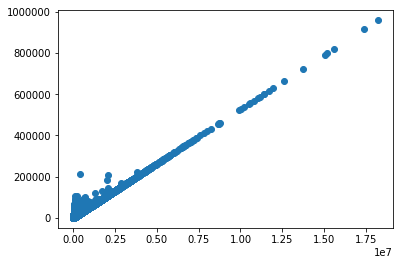

In [63]:
# dfSummary.plot('sumShopCounts', 'avgCounts')
plt.scatter(dfSummary['sumShopCounts'], dfSummary['avgCounts'])

In [66]:
dfSummary['rankSumCount'] = dfSummary['sumShopCounts'].rank(ascending=False)
dfSummary['rankAvgCount'] = dfSummary['avgCounts'].rank(ascending=False)

In [67]:
dfSummary.head(20)

,sumShopCounts,numDays,avgCounts,rankSumCount,rankAvgCount
DME-IST,18207752,19,958302.736842,1.0,1.0
VKO-IST,17371278,19,914277.789474,2.0,2.0
LHR-BKK,15574203,19,819694.894737,3.0,3.0
VKO-SAW,15167688,19,798299.368421,4.0,4.0
ICN-BKK,15041679,19,791667.315789,5.0,5.0
SIN-BKK,13734462,19,722866.421053,6.0,6.0
SVO-IST,12598152,19,663060.631579,7.0,7.0
BKK-ICN,11971504,19,630079.157895,8.0,8.0
DME-SAW,11683567,19,614924.578947,9.0,9.0
BKK-HKT,11428250,19,601486.842105,10.0,10.0


In [69]:
dfSummary[dfSummary['rankAvgCount'] != dfSummary['rankSumCount']].head(20)

,sumShopCounts,numDays,avgCounts,rankSumCount,rankAvgCount
LGW-BOM,4272367,19,224861.421053,139.0,140.0
DME-EVN,4270988,19,224788.842105,140.0,141.0
YYZ-DEL,4266663,19,224561.210526,141.0,142.0
DEL-LGW,4266641,19,224560.052632,142.0,143.0
MIA-EWR,4249987,19,223683.526316,143.0,144.0
SNA-SFO,4225600,19,222400.000000,144.0,145.0
DXB-LGW,4220038,19,222107.263158,145.0,146.0
SNA-EWR,4219644,19,222086.526316,146.0,147.0
HKT-DMK,4217598,19,221978.842105,147.0,148.0
SAW-DME,4215482,19,221867.473684,148.0,149.0


In [72]:
top1000sum = list(dfSummary.sort_values(by='sumShopCounts', ascending=False)[:1000].index)

In [73]:
top1000sum[:10]

['DME-IST',
 'VKO-IST',
 'LHR-BKK',
 'VKO-SAW',
 'ICN-BKK',
 'SIN-BKK',
 'SVO-IST',
 'BKK-ICN',
 'DME-SAW',
 'BKK-HKT']

In [74]:
top1000sum[-20:]

['SEA-OAK',
 'HAN-SIN',
 'ORY-BCN',
 'BUR-SEA',
 'KWI-DXB',
 'BKK-MEL',
 'HKT-CNX',
 'MAD-AEP',
 'LAX-SLC',
 'DXB-JFK',
 'CDG-MXP',
 'SIN-CDG',
 'ICN-ORY',
 'PVG-BKK',
 'LHR-HAN',
 'ORY-DXB',
 'LAX-BKK',
 'MXP-LCY',
 'MEL-SIN',
 'SEA-ONT']

In [76]:
top1000avg = list(dfSummary.sort_values(by='avgCounts', ascending=False)[:1000].index)

In [77]:
diff = list(set(top1000sum) - set(top1000avg))

In [78]:
len(diff)

16

In [79]:
diff

['MXP-LCY',
 'LHR-HAN',
 'BUR-SEA',
 'MAD-AEP',
 'SEA-ONT',
 'LAX-BKK',
 'ICN-ORY',
 'LAX-SLC',
 'DXB-JFK',
 'CDG-MXP',
 'BKK-MEL',
 'HKT-CNX',
 'SIN-CDG',
 'MEL-SIN',
 'KWI-DXB',
 'PVG-BKK']

In [85]:
dfSummary.loc[diff]

,sumShopCounts,numDays,avgCounts,rankSumCount,rankAvgCount
MXP-LCY,1445454,19,76076.526316,998.0,1016.0
LHR-HAN,1447211,19,76169.000000,995.0,1012.0
BUR-SEA,1460752,19,76881.684211,984.0,1001.0
MAD-AEP,1457412,19,76705.894737,988.0,1005.0
SEA-ONT,1444242,19,76012.736842,1000.0,1018.0
LAX-BKK,1445954,19,76102.842105,997.0,1015.0
ICN-ORY,1450572,19,76345.894737,993.0,1010.0
LAX-SLC,1456163,19,76640.157895,989.0,1006.0
DXB-JFK,1455546,19,76607.684211,990.0,1007.0
CDG-MXP,1454202,19,76536.947368,991.0,1008.0


Probably doesnt matter. Take raw counts

In [86]:
dfSummary.reset_index(inplace=True)

In [89]:
dfSummary.rename(columns={'index':'market'}, inplace=True)

In [90]:
dfSummary.head()

,market,sumShopCounts,numDays,avgCounts,rankSumCount,rankAvgCount
0,DME-IST,18207752,19,958302.736842,1.0,1.0
1,VKO-IST,17371278,19,914277.789474,2.0,2.0
2,LHR-BKK,15574203,19,819694.894737,3.0,3.0
3,VKO-SAW,15167688,19,798299.368421,4.0,4.0
4,ICN-BKK,15041679,19,791667.315789,5.0,5.0


In [91]:
dfSummary.columns

Index(['market', 'sumShopCounts', 'numDays', 'avgCounts', 'rankSumCount',
       'rankAvgCount'],
      dtype='object')

In [92]:
dfSummary[['market', 'sumShopCounts', 'numDays', 'rankSumCount']].to_csv('./output/top_markets_summary.csv', index=False)

In [95]:
top1000sum[:10]

['DME-IST',
 'VKO-IST',
 'LHR-BKK',
 'VKO-SAW',
 'ICN-BKK',
 'SIN-BKK',
 'SVO-IST',
 'BKK-ICN',
 'DME-SAW',
 'BKK-HKT']

In [96]:
topData = [(x,) for x in top1000sum]

In [97]:
sparkDfTop = spark.createDataFrame(topData, schema=T.StructType(
    [T.StructField("market_key", T.StringType(), nullable=False)]
                                  ))

In [98]:
sparkDfTop.show(10)

+----------+
|market_key|
+----------+
|   DME-IST|
|   VKO-IST|
|   LHR-BKK|
|   VKO-SAW|
|   ICN-BKK|
|   SIN-BKK|
|   SVO-IST|
|   BKK-ICN|
|   DME-SAW|
|   BKK-HKT|
+----------+
only showing top 10 rows



In [99]:
markets_path = "/user/kendra.frederick/shop_grid/markets.csv"

In [100]:
sparkDfTop.write.csv(markets_path, header=True)

In [101]:
markets_df = spark.read.csv(markets_path, header=True)

In [102]:
markets_df.show()

+----------+
|market_key|
+----------+
|   DME-IST|
|   VKO-IST|
|   LHR-BKK|
|   VKO-SAW|
|   ICN-BKK|
|   SIN-BKK|
|   SVO-IST|
|   BKK-ICN|
|   DME-SAW|
|   BKK-HKT|
|   LHR-JFK|
|   VKO-AYT|
|   BKK-CNX|
|   BKK-SIN|
|   LHR-EWR|
|   LHR-DEL|
|   LHR-DXB|
|   HKG-LHR|
|   LHR-IST|
|   IST-DME|
+----------+
only showing top 20 rows

